In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary

import tensorflow as tf
import gpflow

from sklearn.model_selection import train_test_split

def set_season(x):
    if x in [3,4,5]:
        return 1
    if x in [6,7,8]:
        return 2
    if x in [9,10,11]:
        return 3 
    else:
        return 4

data = pd.read_csv('birth_data.csv')
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['ids'] = np.arange(1, data.shape[0]+1)
data['weekday'] = data.day_of_week.apply(lambda x: 1 if x in [1,2,3,4,5] else 0)
data['births_relative100'] = data.births.apply(lambda x: x/np.mean(data.births)*100)
data['seasons'] = data.month.apply(set_season)

x = data.ids
y = data.births

x = tf.cast(x, tf.float64)
y = tf.cast(y, tf.float64)

x = tf.reshape(x, [7305,1])
y = tf.reshape(y, [7305,1])

2022-06-09 10:20:28.989000: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-09 10:20:29.497611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10792 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [ ]:
### Trying Kernels

In [7]:
k = gpflow.kernels.Matern52()
#k = gpflow.kernels.RBF()
print('Kernel Parameter Summary')
print_summary(k)
gp1 = gpflow.models.GPR(data=(x, y), kernel=k, mean_function=None)
print('GP model Parameter Summary')
print_summary(gp1)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gp1.training_loss, gp1.trainable_variables)
print('Optimisation Summary')
print_summary(gp1)

Kernel Parameter Summary
╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Matern52.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Matern52.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛
GP model Parameter Summary
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ 

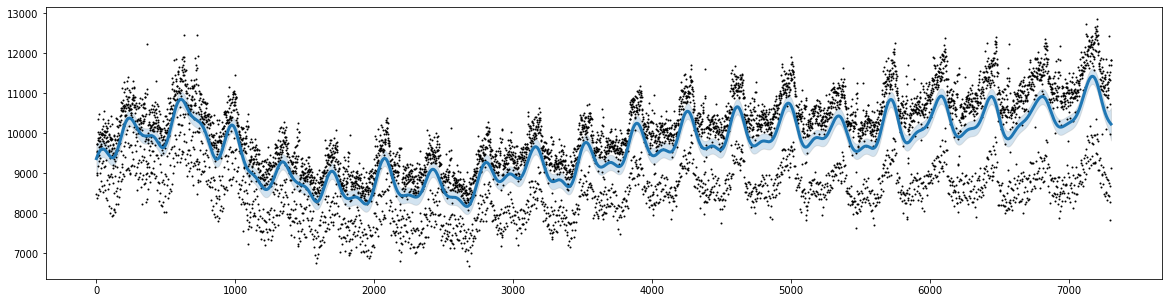

In [16]:
## predict mean and variance of latent GP at sample points
mu, var = gp1.predict_f(x)

plt.figure(figsize=(20,5))
plt.plot(x, y, '.', label='true data', c='black', markersize=2)
plt.plot(x, mu, '-', label='pred', c='C0', linewidth=3)
vv = 1.96 * np.sqrt(var) #+ sigma_n ** 2
plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')
plt.title('Matern52')

In [17]:
k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
#k = gpflow.kernels.RBF()
gp1 = gpflow.models.GPR(data=(x, y), kernel=k, mean_function=None)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gp1.training_loss, gp1.trainable_variables)
print('Optimisation Summary')
print_summary(gp1)

2022-06-08 14:33:43.003762: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:202] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-06-08 14:33:46.106926: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:202] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-06-08 14:33:49.209791: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:202] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-06-08 14:33:52.316377: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:202] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-06-08 14:33:55.432063: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:202] Cholesky decomposition was not successful for ba

Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │             value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 416278            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      5.66097e-113 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[1].variance     │ Pa

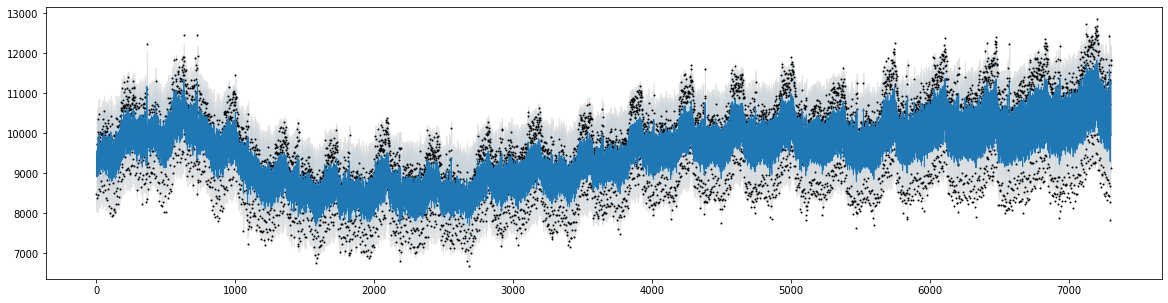

In [19]:
mu, var = gp1.predict_f(x)

plt.figure(figsize=(20,5))
plt.plot(x, y, '.', label='true data', c='black', markersize=2)
plt.plot(x, mu, '-', label='pred', c='C0', linewidth=1)
vv = 1.96 * np.sqrt(var) #+ sigma_n ** 2
plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')
plt.title('Matern52 + RBF')

In [ ]:
### Only on weekdays

In [3]:
data_weekdays = data.loc[data.weekday==1]

x_w = (data_weekdays.ids)
x_w = tf.cast(x_w, tf.float64)
x_w = np.reshape(x_w, (x_w.shape[0],1))

y_w = data_weekdays.births
y_wc = y_w - np.mean(y_w)
y_w = np.reshape(y_w.to_numpy(), (x_w.shape[0],1))
y_wc = np.reshape(y_wc.to_numpy(), (x_w.shape[0],1))

In [ ]:
### More automatic fitting and predicting
### Test more kernels

In [13]:
def gp_fit_pred(x, y, k, title, zoom_in=None):
    
    gp = gpflow.models.GPR(data=(x, y), kernel=k, mean_function=None)
    #print('LML BEFORE the optimisation: %f' % gp.compute_log_likelihood())
    
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(gp.training_loss, gp.trainable_variables)
    print('Optimisation Summary')
    print_summary(gp)
    #print('LML AFTER the optimisation: %f' % gp.compute_log_likelihood())
    
    mu, var = gp.predict_f(x)
    plt.figure(figsize=(20,5))
    plt.plot(x, y, '.', label='true data', c='black', markersize=2)
    plt.plot(x, mu, '-', label='pred', c='C0', linewidth=3)
    vv = 1.96 * np.sqrt(var) #+ sigma_n ** 2
    plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')
    plt.title(title)
    
    if zoom_in:
        plt.figure(figsize=(20,5))
        plt.plot(x[:100], y[:100], '.', label='true data', c='black', markersize=4)
        plt.plot(x[:100], mu[:100], '-', label='pred', c='C0', linewidth=2)
        vv = 1.96 * np.sqrt(var) #+ sigma_n ** 2
        plt.fill_between(x[:100,0], (mu-vv)[:100,0], (mu+vv)[:100,0], alpha=0.2, edgecolor='gray', facecolor='C0')
        plt.title(title + ' + zoom_in')


Optimisation Summary
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      1.00899 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 104633       │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  15777.6     │
╘═════════════════════════╧════════

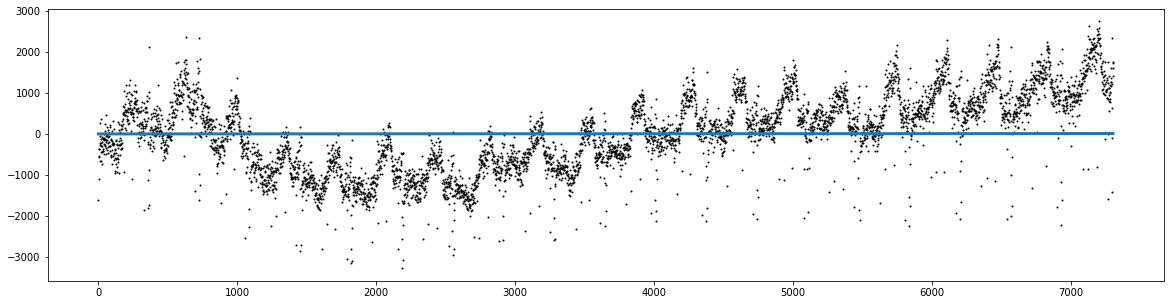

In [12]:
k = gpflow.kernels.Cosine()
gp_fit_pred(x_w, y_wc, k, title='Cosine')

Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │         value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     1.00168   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     0.0589154 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │

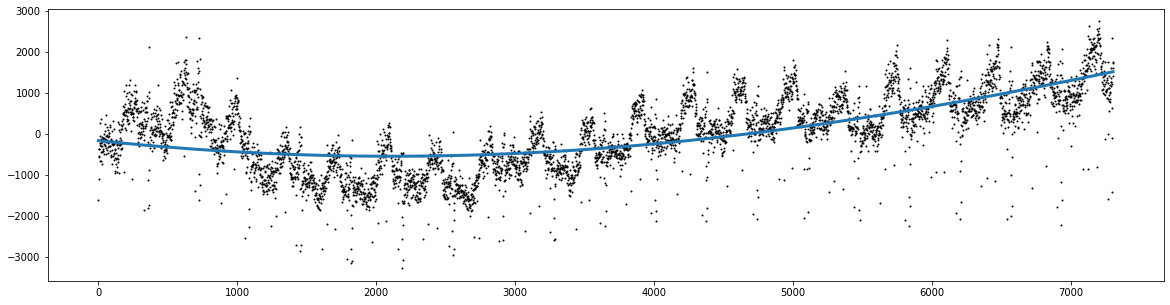

In [11]:
k = gpflow.kernels.Cosine() + gpflow.kernels.RBF()
gp_fit_pred(x_w, y_wc, k, title='Cosine + RBF')

Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │             value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  84717.1          │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      3.33624e-141 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[1].variance     │ Pa

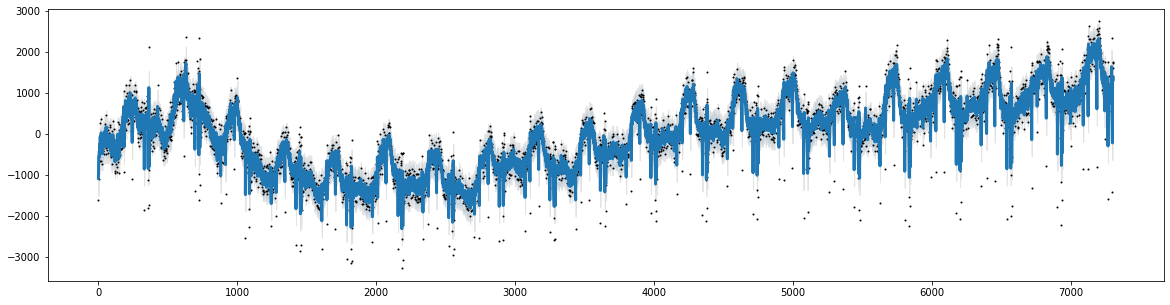

In [10]:
k = gpflow.kernels.Matern32() + gpflow.kernels.RBF()
gp_fit_pred(x_w, y_wc, k, title='Matern32 + RBF')

Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │            value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  84731.5         │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      5.1415e-116 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter

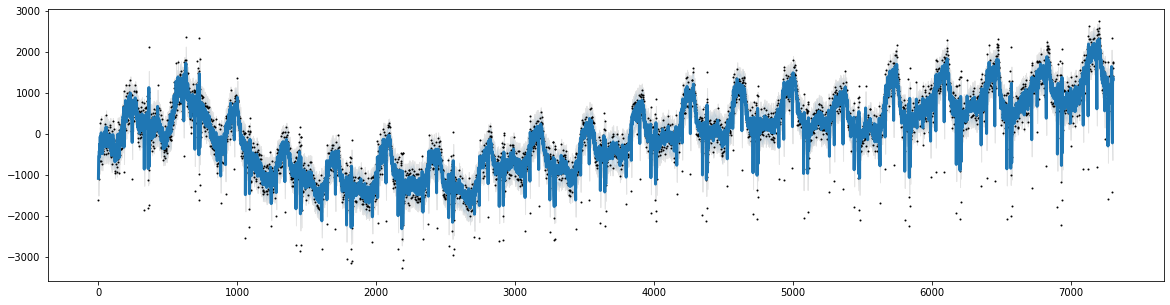

In [9]:
k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
gp_fit_pred(x_w, y_wc, k, title='Matern52 + RBF')

2022-06-09 08:39:41.020559: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-06-09 08:39:55.023196: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55aecd908c90


Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │             value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  84516.8          │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      3.54119e-125 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[1].variance     │ Pa

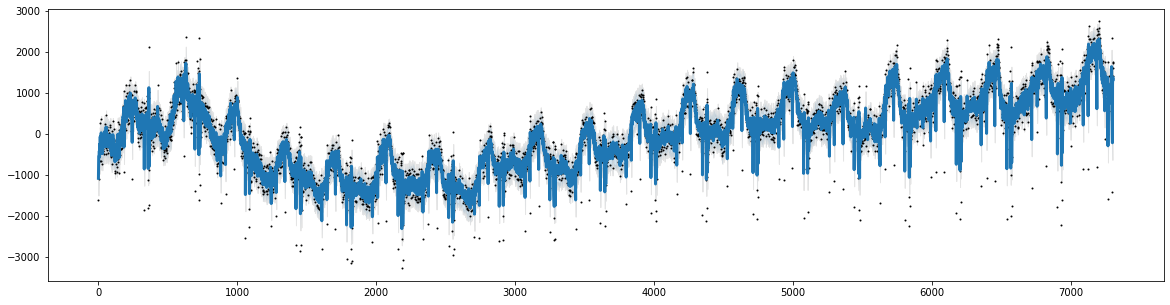

In [5]:
k = gpflow.kernels.Matern12() + gpflow.kernels.RBF()
gp_fit_pred(x_w, y_wc, k, title='Matern12 + RBF')

Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │            value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  84731.5         │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      5.1415e-116 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter

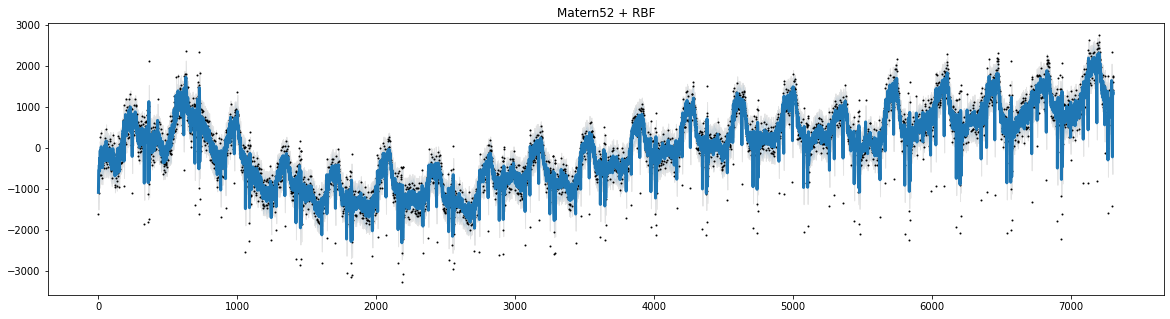

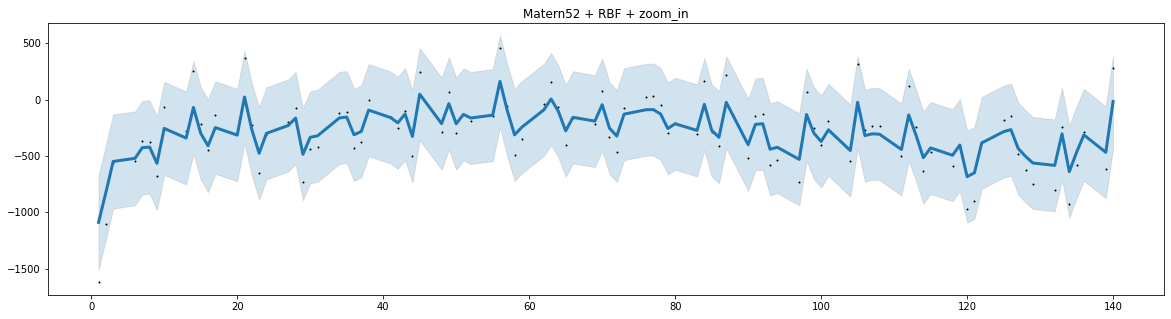

In [19]:
k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
gp_fit_pred(x_w, y_wc, k, title='Matern52 + RBF', zoom_in=True)

<AxesSubplot:xlabel='date', ylabel='births'>

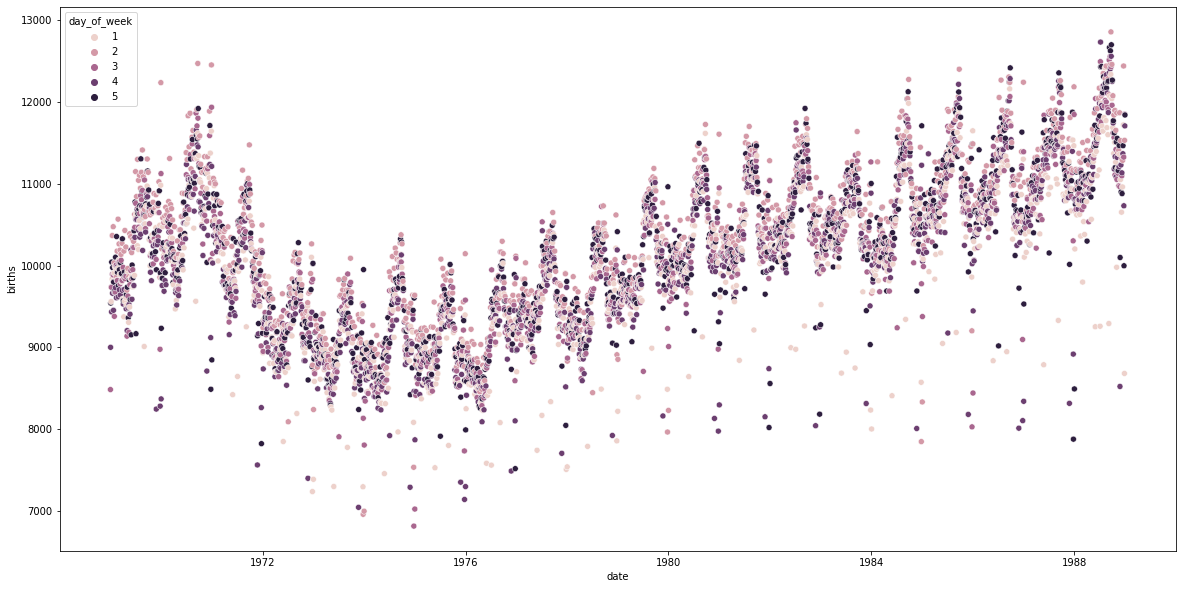

In [9]:
# check what the lower births might signify - EDA

plt.figure(figsize=(20,10))
sns.scatterplot(data=data_weekdays, x='date', y='births', hue='day_of_week')
# its a mix of days

Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 932.142      │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  15.0809     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │       

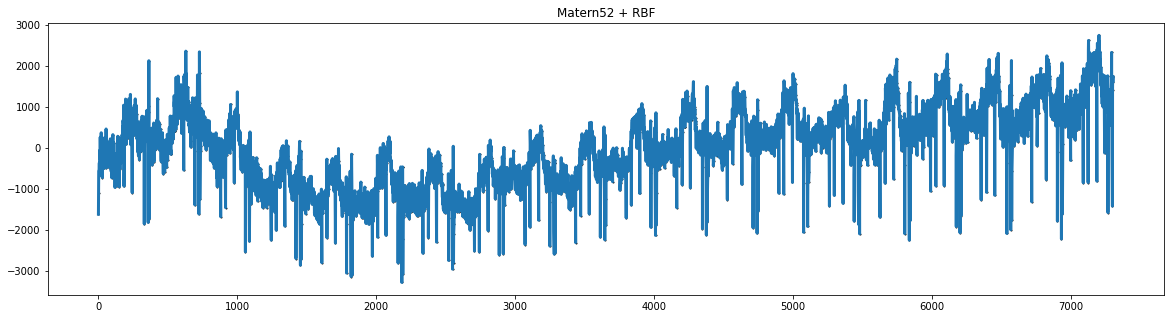

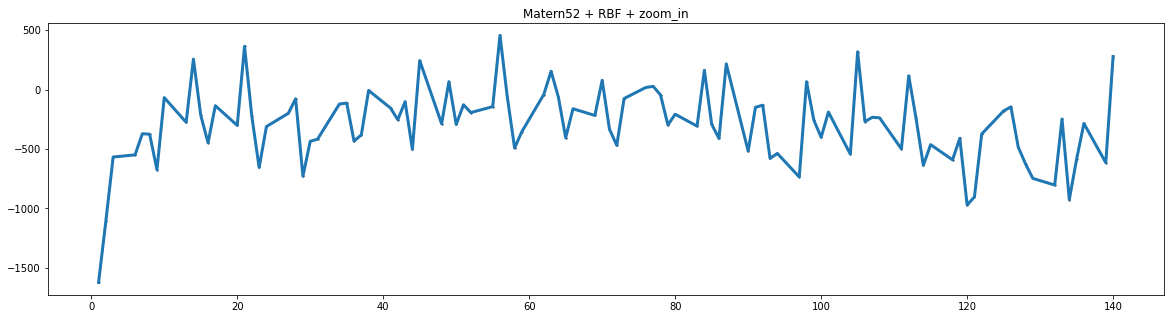

In [20]:
k = gpflow.kernels.Matern52() * gpflow.kernels.RBF()
gp_fit_pred(x_w, y_wc, k, title='Matern52 * RBF', zoom_in=True)

Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  869.009   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    2.04515 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True      

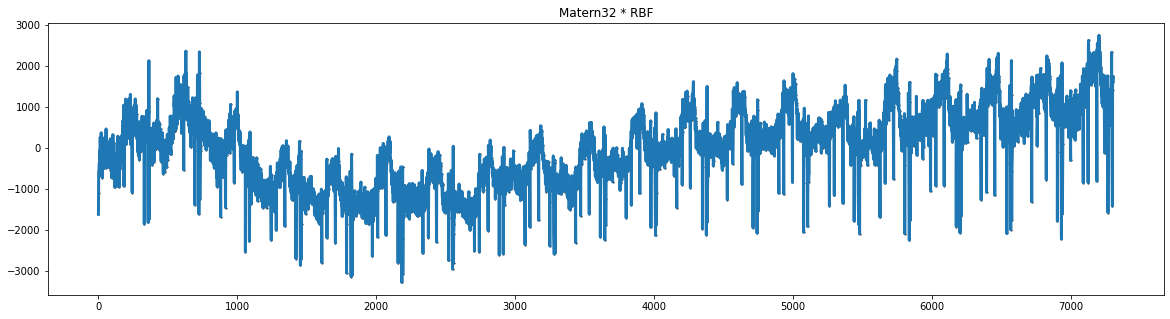

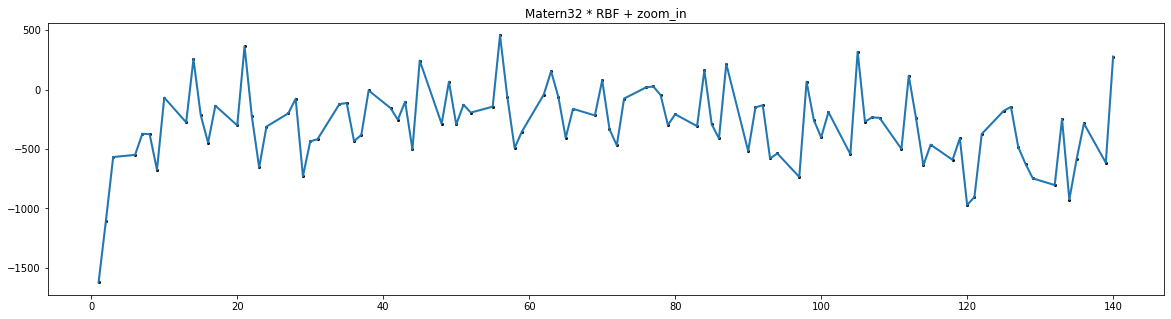

In [24]:
k = gpflow.kernels.Matern32() * gpflow.kernels.RBF()
gp_fit_pred(x_w, y_wc, k, title='Matern32 * RBF', zoom_in=True)

In [ ]:
### Random data split
# for weekday centered data

In [4]:
df_train, df_test = train_test_split(data_weekdays, test_size=0.3, random_state=42)
df_train = df_train.sort_values(by='ids')
df_test = df_test.sort_values(by='ids')

x_train = (df_train.ids)
x_train = tf.cast(x_train, tf.float64)
x_train = np.reshape(x_train, (x_train.shape[0],1))

x_test = (df_test.ids)
x_test = tf.cast(x_test, tf.float64)
x_test = np.reshape(x_test, (x_test.shape[0],1))

y_train = df_train.births
y_train = y_train - np.mean(y_train)
y_train = np.reshape(y_train.to_numpy(), (x_train.shape[0],1))

y_test = df_test.births
y_test = y_test - np.mean(y_test)
y_test = np.reshape(y_test.to_numpy(), (x_test.shape[0],1))

In [5]:
def gp_datasplit(x, y, k, title, zoom_in=None, x_test=None, y_test=None, zoom_in_test=None):
    
    gp = gpflow.models.GPR(data=(x, y), kernel=k, mean_function=None)
    #print('LML BEFORE the optimisation: %f' % gp.compute_log_likelihood())
    
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(gp.training_loss, gp.trainable_variables)
    print('Optimisation Summary')
    print_summary(gp)
    #print('LML AFTER the optimisation: %f' % gp.compute_log_likelihood())
    
    mu, var = gp.predict_f(x)
    plt.figure(figsize=(20,5))
    plt.plot(x, y, '.', label='true data', c='black', markersize=4)
    plt.plot(x, mu, '-', label='pred', c='C0', linewidth=3)
    vv = 1.96 * np.sqrt(var) #+ sigma_n ** 2
    plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')
    plt.title(title + ' - train dataset')
    plt.show()
    
    if zoom_in:
        plt.figure(figsize=(20,5))
        plt.plot(x[:100], y[:100], '.', label='true data', c='black', markersize=4)
        plt.plot(x[:100], mu[:100], '-', label='pred', c='C0', linewidth=2)
        vv = 1.96 * np.sqrt(var) #+ sigma_n ** 2
        plt.fill_between(x[:100,0], (mu-vv)[:100,0], (mu+vv)[:100,0], alpha=0.2, edgecolor='gray', facecolor='C0')
        plt.title(title + ' - train dataset (zoom_in)')
        plt.show()
        
    if x_test is not None:
        mu_test, var_test = gp.predict_f(x_test)
        plt.figure(figsize=(20,5))
        plt.plot(x_test, y_test, '.', label='true test data', c='black', markersize=2)
        plt.plot(x_test, mu_test, 'x-', label='pred', c='C0', linewidth=3)
        vv = 1.96 * np.sqrt(var_test) #+ sigma_n ** 2
        plt.fill_between(x_test[:,0], (mu_test-vv)[:,0], (mu_test+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')
        plt.title(title + ' - test dataset')
        plt.show()
        
        plt.figure(figsize=(20,5))
        plt.plot(x_test, y_test, '.', label='true test data', c='black', markersize=3)
        plt.plot(x, mu, '-', label='fitted model', c='C0', linewidth=3)
        vv = 1.96 * np.sqrt(var) #+ sigma_n ** 2
        plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')
        plt.plot(x_test, mu_test, 'x', label='pred', c='red', linewidth=3)
        plt.title(title + ' - test dataset and fitted model')
        plt.legend()
        plt.show()
    
        if zoom_in_test:
            plt.figure(figsize=(20,5))
            plt.plot(x_test[:300], y_test[:300], '.', label='true test data', c='black', markersize=3)
            plt.plot(x[:300], mu[:300], '-', label='fitted model', c='C0', linewidth=3)
            vv = 1.96 * np.sqrt(var) #+ sigma_n ** 2
            plt.fill_between(x[:300,0], (mu-vv)[:300,0], (mu+vv)[:300,0], alpha=0.2, edgecolor='gray', facecolor='C0')
            plt.plot(x_test[:300], mu_test[:300], 'x', label='pred', c='red', linewidth=3)
            plt.title(title + ' - test dataset (zoom in)')
            plt.legend()
            plt.show()


Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │             value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  91335.5          │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      6.38984e-126 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[1].variance     │ Pa

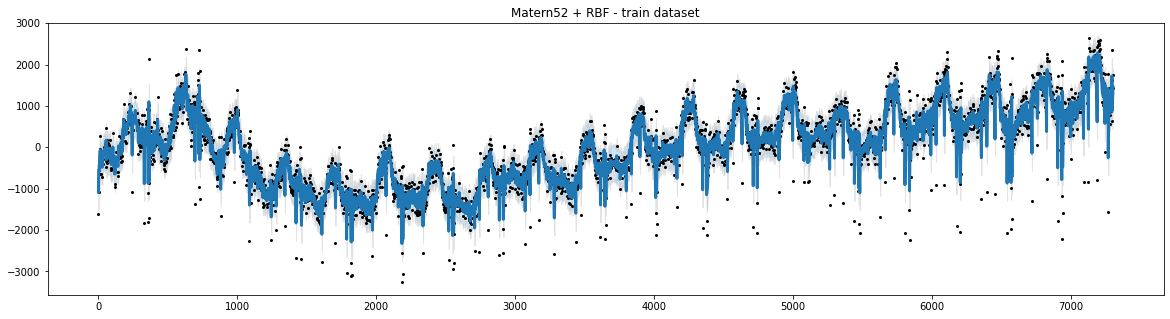

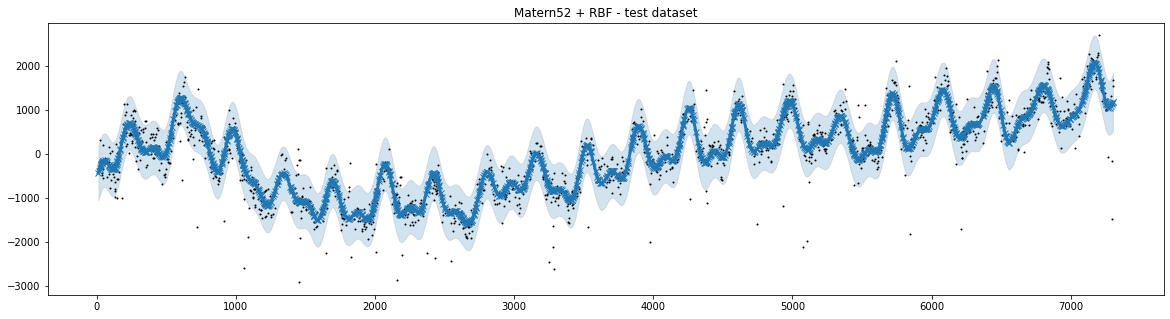

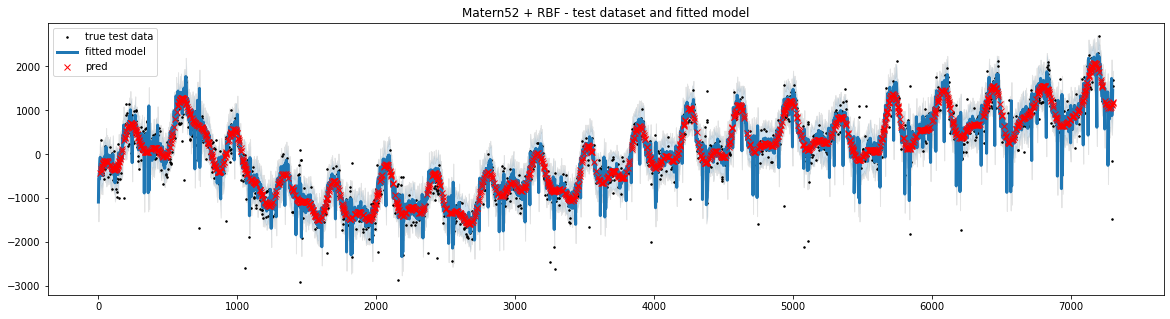

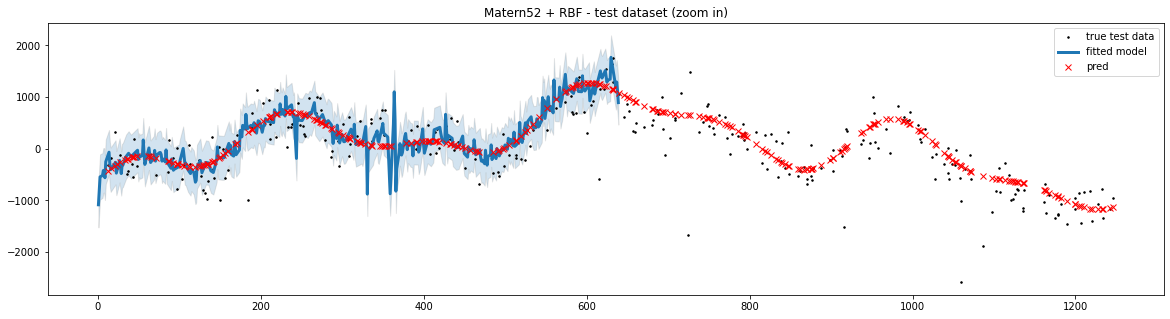

In [7]:
k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
gp_datasplit(x_train, y_train, k, title='Matern52 + RBF', x_test=x_test, y_test=y_test, zoom_in_test=True)

In [ ]:
### Non-random data split

2022-06-09 10:29:11.908556: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:202] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-06-09 10:29:12.997662: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:202] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-06-09 10:29:14.095650: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:202] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-06-09 10:29:15.262088: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:202] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-06-09 10:29:16.390308: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:202] Cholesky decomposition was not successful for ba

Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │             value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  82015.7          │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      3.75355e-122 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[1].variance     │ Pa

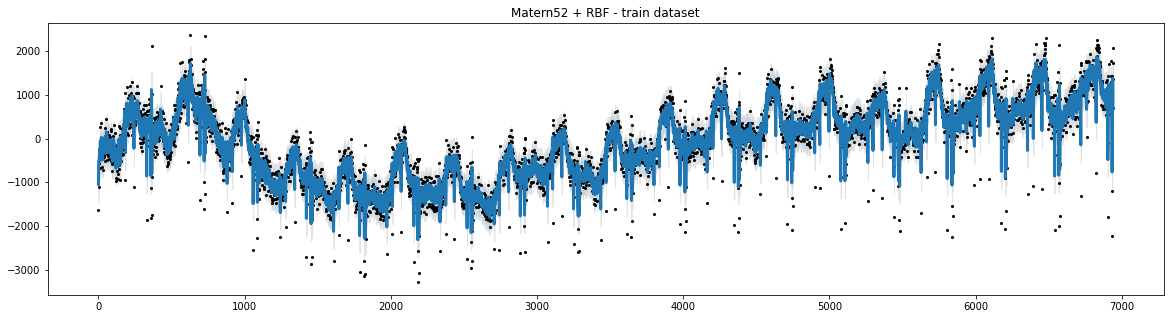

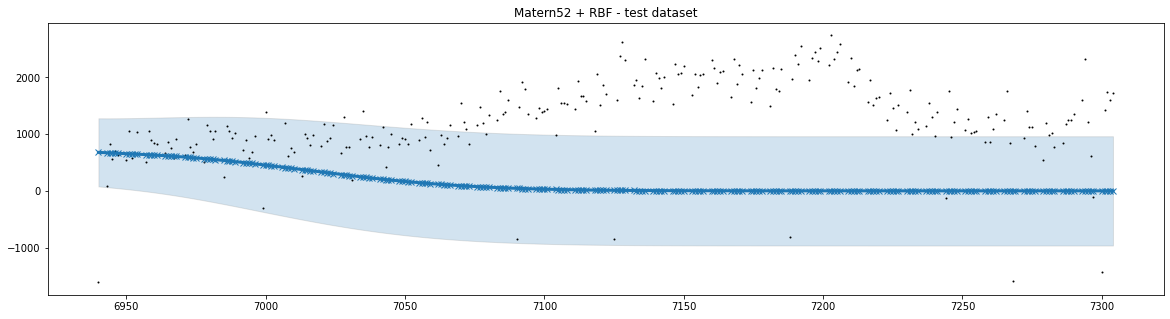

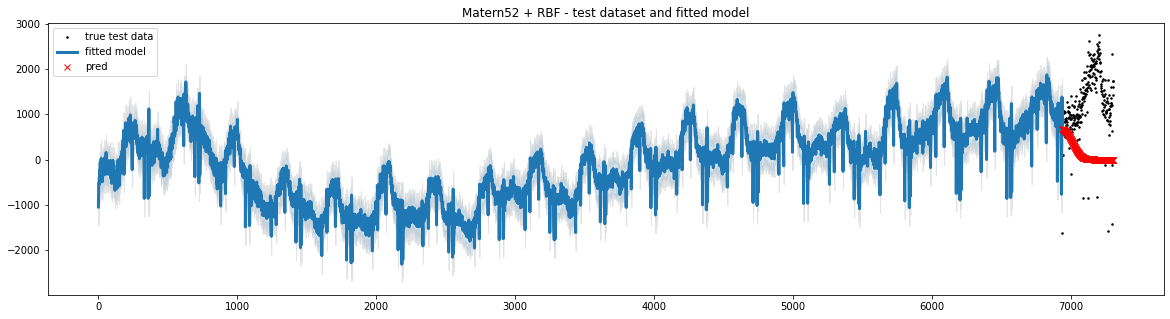

In [11]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_w, y_wc, test_size=0.05, random_state=42, shuffle=False)

k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
gp_datasplit(x_train1, y_train1, k, title='Matern52 + RBF', x_test=x_test1, y_test=y_test1)

In [ ]:
### Weekends

In [12]:
data_weekends = data.loc[data.weekday==0]

x_ww = (data_weekends.ids)
x_ww = tf.cast(x_ww, tf.float64)
x_ww = np.reshape(x_ww, (x_ww.shape[0],1))

y_ww = data_weekends.births
y_ww = y_ww - np.mean(y_ww)
y_ww = np.reshape(y_ww.to_numpy(), (x_ww.shape[0],1))

Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 95813.7    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    51.4698 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True      

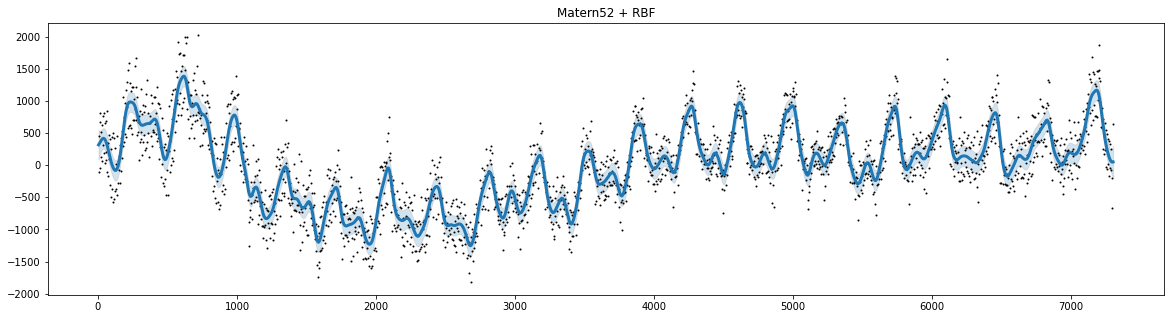

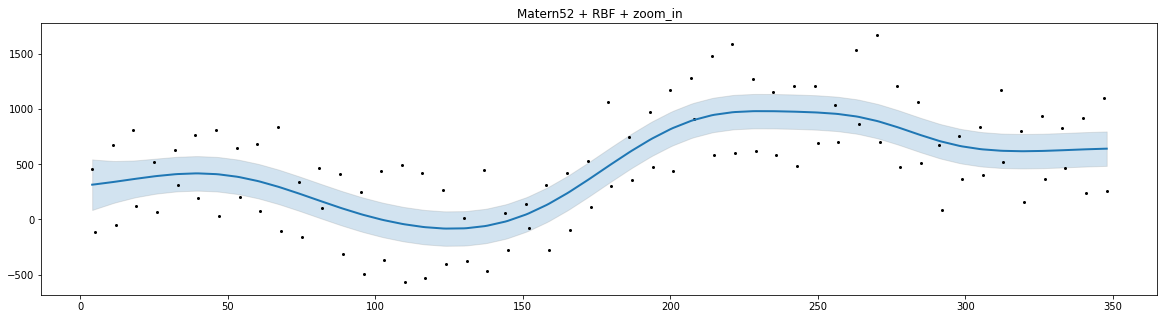

In [14]:
k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
gp_fit_pred(x_ww, y_ww, k, title='Matern52 + RBF', zoom_in=True)

In [16]:
df_wtrain, df_wtest = train_test_split(data_weekends, test_size=0.3, random_state=42)
df_wtrain = df_wtrain.sort_values(by='ids')
df_wtest = df_wtest.sort_values(by='ids')

x_wtrain = (df_wtrain.ids)
x_wtrain = tf.cast(x_wtrain, tf.float64)
x_wtrain = np.reshape(x_wtrain, (x_wtrain.shape[0],1))

x_wtest = (df_wtest.ids)
x_wtest = tf.cast(x_wtest, tf.float64)
x_wtest = np.reshape(x_wtest, (x_wtest.shape[0],1))

y_wtrain = df_wtrain.births
y_wtrain = y_wtrain - np.mean(y_wtrain)
y_wtrain = np.reshape(y_wtrain.to_numpy(), (x_wtrain.shape[0],1))

y_wtest = df_wtest.births
y_wtest = y_wtest - np.mean(y_wtest)
y_wtest = np.reshape(y_wtest.to_numpy(), (x_wtest.shape[0],1))

Optimisation Summary
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │             value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 330380            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     81.654        │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[1].variance     │ Pa

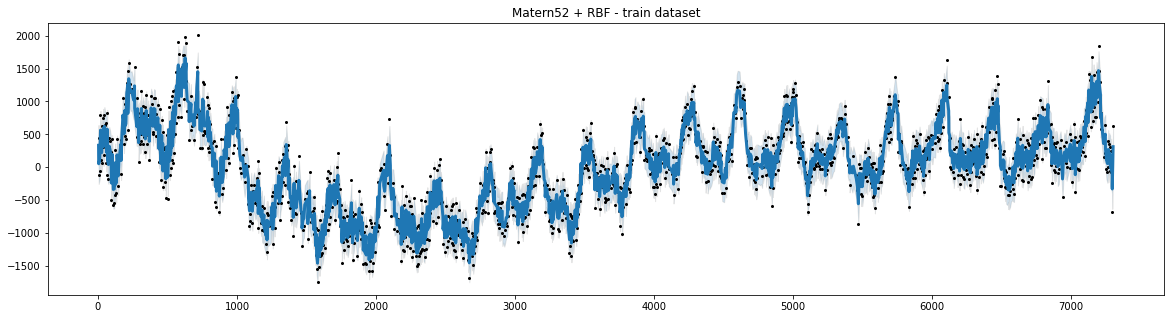

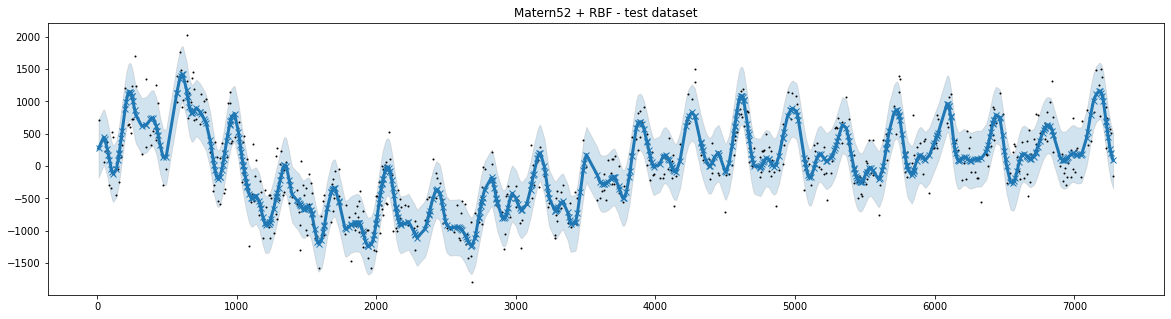

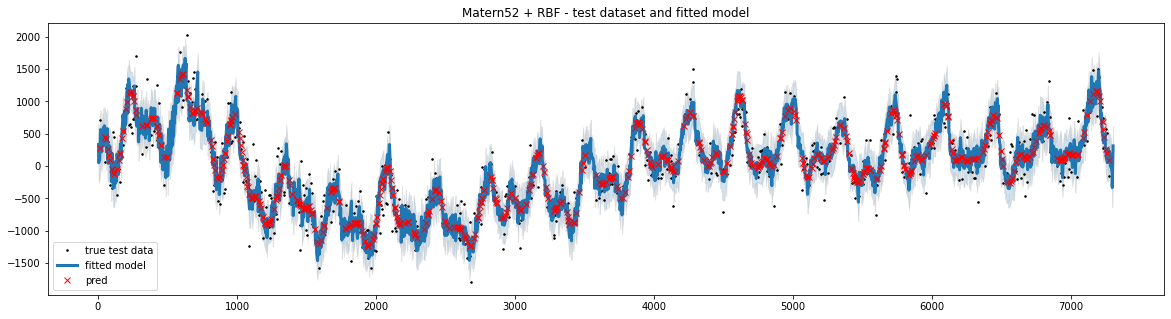

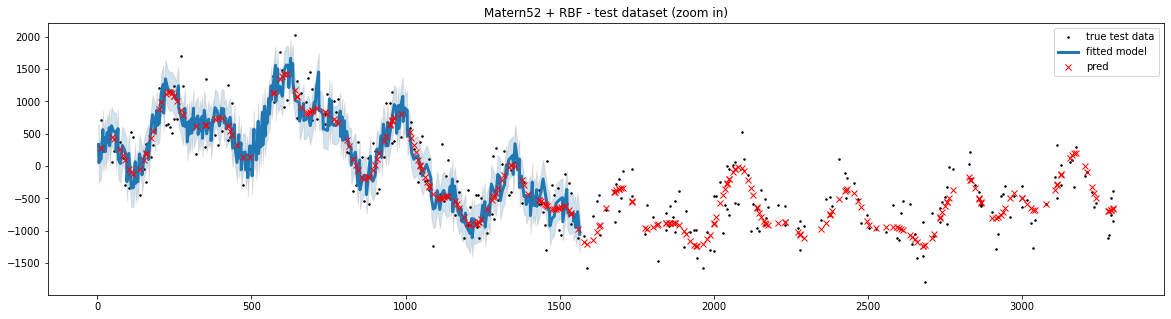

In [17]:
k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
gp_datasplit(x_wtrain, y_wtrain, k, title='Matern52 + RBF', x_test=x_wtest, y_test=y_wtest, zoom_in_test=True)

In [ ]:
### Slidding Window